In [43]:
import pandas as pd 
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt

from keras.models import Sequential, Model
from keras import layers
from keras import Input

from sklearn.preprocessing import LabelEncoder

In [5]:
mlb20 = pd.read_csv('data/2020cleaned.csv')

mlb20.columns

Index(['game_date', 'pitch_type', 'Pitcher_name', 'pitcher_id', 'batter_name',
       'batter_id', 'release_speed', 'release_pos_x', 'release_pos_z', 'stand',
       'p_throws', 'balls', 'strikes', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z',
       'on_3b', 'on_2b', 'on_1b', 'inning', 'inning_topbot', 'effective_speed',
       'release_spin_rate', 'release_extension', 'Catcher', 'FirstBasemen',
       'SecondBasemen', 'ThirdBasemen', 'ShortStop', 'LeftField',
       'CenterField', 'RightField', 'at_bat_number', 'pitch_number',
       'pitch_name', 'bat_score', 'fld_score', 'post_bat_score',
       'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment',
       'count', 'strike_attempt', 'events', 'description', 'type', 'bb_type',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'outs_when_up'],
      dtype='object')

In [3]:
mlb20.head()

,game_date,pitch_type,Pitcher_name,pitcher_id,batter_name,batter_id,release_speed,release_pos_x,release_pos_z,stand,...,description,type,bb_type,vx0,vy0,vz0,ax,ay,az,outs_when_up
0,2020-10-27,FF,Julio Urias,628711,Willy Adames,642715,96.7,1.58,5.99,1,...,called_strike,S,NaN,-5.950264,-140.490456,-7.897391,3.772000,32.321911,-8.981441,2
1,2020-10-27,FF,Julio Urias,628711,Willy Adames,642715,94.1,2.91,5.45,1,...,called_strike,S,NaN,-10.560246,-136.599519,-3.429867,11.723598,29.183810,-15.237217,2
2,2020-10-27,FF,Julio Urias,628711,Willy Adames,642715,94.9,1.77,6.02,1,...,swinging_strike,S,NaN,-5.199252,-138.098234,-4.637970,4.158758,30.838499,-12.535677,2
3,2020-10-27,FF,Julio Urias,628711,Mike Brosseau,670712,94.4,1.66,5.93,1,...,called_strike,S,NaN,-5.843595,-137.294295,-7.414897,4.754147,30.016237,-11.778755,1
4,2020-10-27,CU,Julio Urias,628711,Mike Brosseau,670712,81.4,1.46,6.06,1,...,ball,B,NaN,-0.383207,-118.447810,-4.454166,-15.553576,24.451936,-32.892744,1


In [7]:
mlb20 = mlb20[mlb20['release_speed'].notnull()]
mlb20.isnull().sum()

game_date                     0
pitch_type                    0
Pitcher_name                  0
pitcher_id                    0
batter_name                   0
batter_id                     0
release_speed                 0
release_pos_x                 0
release_pos_z                 0
stand                         0
p_throws                      0
balls                         0
strikes                       0
pfx_x                         0
pfx_z                         0
plate_x                       0
plate_z                       0
on_3b                         0
on_2b                         0
on_1b                         0
inning                        0
inning_topbot                 0
effective_speed               0
release_spin_rate           346
release_extension           587
Catcher                       0
FirstBasemen                  0
SecondBasemen                 0
ThirdBasemen                  0
ShortStop                     0
LeftField                     0
CenterFi

In [57]:
# Selecting branches for multi input
pitch_selection_branch = mlb20['pitch_name']
pitcher_coordinate_branch = mlb20[['release_speed', 'release_pos_x', 'release_pos_z', 'p_throws']]
plate_coordinate_branch = mlb20[['pfx_x', 'pfx_z', 'plate_x', 'plate_z']]
score_branch = mlb20[['bat_score', 'fld_score']]
align_branch = mlb20[['if_fielding_alignment', 'of_fielding_alignment']]
target = mlb20[['strike_attempt']]

In [59]:
le = LabelEncoder().fit(target)
target20 = le.transform(target)

C:\Users\ncesm\anaconda3\envs\capstone\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [60]:
le

LabelEncoder()

In [16]:
pitcher_coordinate_branch.head()

,release_speed,release_pos_x,release_pos_z,p_throws
0,96.7,1.58,5.99,0
1,94.1,2.91,5.45,0
2,94.9,1.77,6.02,0
3,94.4,1.66,5.93,0
4,81.4,1.46,6.06,0


In [17]:
plate_coordinate_branch.head()

,pfx_x,pfx_z,plate_x,plate_z
0,0.2,1.6,-0.53,2.29
1,0.8,1.3,-0.55,3.03
2,0.2,1.5,-0.04,3.32
3,0.3,1.5,-0.37,2.15
4,-1.7,-0.2,-0.14,0.96


In [18]:
score_branch.head()

,bat_score,fld_score
0,1,3
1,1,3
2,1,3
3,1,3
4,1,3


In [63]:
pitcher_coordinate_branch.shape

(279652, 4)

In [64]:
plate_coordinate_branch.shape

(279652, 4)

## Training on 2020 Season

In [78]:
# model = Sequential()

release_input = Input(shape=(None,4),name='pitcher_coordinates')
plate_input = Input(shape=(None,4),name='plate_coordinates')

concatenated = layers.concatenate([release_input, plate_input])

aim = layers.Dense(1, activation='softmax')(concatenated) # Answer between 'strike','out','ball','ob'

model = Model([release_input, plate_input], aim)
model.compile(optimizer='adam',
              loss=['mse','categorical_crossentropy'],
              metrics=['acc'])

## Testing on 2019 season

In [79]:
hist = model.fit({'pitcher_coordinates':pitcher_coordinate_branch19, 'plate_coordinates':plate_coordinate_branch19},
                 target19_encoded, # does this need to be one hot encoded
                 epochs=10, batch_size=128)

Epoch 1/10
5765/5765 [==============================] - 2s 422us/step - loss: nan - acc: 0.3570
Epoch 2/10
5765/5765 [==============================] - 2s 418us/step - loss: nan - acc: 0.3599
Epoch 3/10
5765/5765 [==============================] - 2s 418us/step - loss: nan - acc: 0.3599
Epoch 4/10
5765/5765 [==============================] - 2s 411us/step - loss: nan - acc: 0.3599
Epoch 5/10
5765/5765 [==============================] - 2s 421us/step - loss: nan - acc: 0.3599
Epoch 6/10
5765/5765 [==============================] - 2s 430us/step - loss: nan - acc: 0.3599
Epoch 7/10
5765/5765 [==============================] - 2s 419us/step - loss: nan - acc: 0.3599
Epoch 8/10
5765/5765 [==============================] - 2s 413us/step - loss: nan - acc: 0.3599
Epoch 9/10
5765/5765 [==============================] - 2s 410us/step - loss: nan - acc: 0.3599
Epoch 10/10
5765/5765 [==============================] - 2s 410us/step - loss: nan - acc: 0.3599


In [80]:
hist.history

{'loss': [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
 'acc': [0.35695531964302063,
  0.3598869740962982,
  0.3598869740962982,
  0.3598869740962982,
  0.3598869740962982,
  0.3598869740962982,
  0.3598869740962982,
  0.3598869740962982,
  0.3598869740962982,
  0.3598869740962982]}

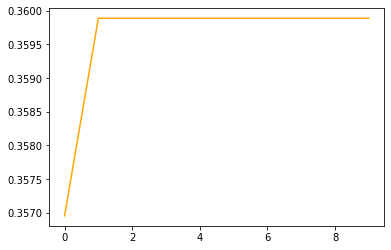

In [81]:
# Check how 2020 data did against 2019 data
plt.plot(hist.epoch, hist.history['acc'], c='orange')
plt.plot(hist.epoch, hist.history['loss'], c='b')

In [40]:
mlb19 = pd.read_csv('data/2019cleaned.csv')
mlb19.isnull().sum()

game_date                     0
pitch_type                    0
Pitcher_name                  0
pitcher_id                    0
batter_name                   0
batter_id                     0
release_speed                 2
release_pos_x                 0
release_pos_z                 0
stand                         0
p_throws                      0
balls                         0
strikes                       0
pfx_x                         0
pfx_z                         0
plate_x                       0
plate_z                       0
on_3b                         0
on_2b                         0
on_1b                         0
inning                        0
inning_topbot                 0
effective_speed               2
release_spin_rate         12807
release_extension             2
Catcher                       0
FirstBasemen                  0
SecondBasemen                 0
ThirdBasemen                  0
ShortStop                     0
LeftField                     0
CenterFi

In [39]:
mlb19 = mlb19[mlb19['release_pos_x'].notnull()]

In [41]:
# Test begins here
pitcher_coordinate_branch19 = mlb19[['release_speed', 'release_pos_x', 'release_pos_z', 'p_throws']]
plate_coordinate_branch19 = mlb19[['pfx_x', 'pfx_z', 'plate_x', 'plate_z']]

In [71]:
pitcher_coordinate_branch19.head()

,release_speed,release_pos_x,release_pos_z,p_throws
0,87.9,-2.65,5.50,1
1,95.9,-2.77,5.52,1
2,96.5,-2.68,5.42,1
3,96.0,-2.65,5.55,1
4,86.7,-2.73,5.59,1


In [72]:
plate_coordinate_branch19.head()

,pfx_x,pfx_z,plate_x,plate_z
0,0.0,0.2,0.88,1.03
1,-0.6,1.5,-0.47,1.92
2,-0.7,1.4,1.68,1.35
3,-0.8,1.5,0.75,2.05
4,-0.1,0.5,1.27,2.17


In [53]:
target19 = mlb19['strike_attempt']
target19

0         strike
1         strike
2           ball
3         strike
4           ball
           ...  
742878    strike
742879    strike
742880    strike
742881    strike
742882       out
Name: strike_attempt, Length: 737815, dtype: object

In [61]:
target19_encoded = le.transform(target19)

In [ ]:
# Rachel tasks

# Follow up with Rachel after Riley meeting
# Reach out to one of the folks on Activision and ask for Informational Interview and talk about commonality of GA
# Reach out to people in the cohort and ask about how they feeling or something or proactive and stuff, SIMP together